# English-Spanish Translation: Switch Transformer
## Table of Contents
* Overview
* Setup
* Import datasets
* Model Development
* Transalation
* References

## Overview
In this Notebook, I will develop a English-Spanish Translation Model using Switch Transformer from scratch. Please be noted that running this notebook is 10 times slower than Google Colab when using GPU. So I set this notebook download the pretrained Model to speed up the training.

## Setup

In [ ]:
import tensorflow as tf
# Install Tensorflow 2.6.0 if needed.
if tf.__version__ < "2.6.0":
    !pip install -q tensorflow==2.6.0
    import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
class Config:
    vocab_size = 15000 # Vocabulary Size
    sequence_length = 20
    batch_size = 64
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 2
    epochs = 1 # Number of Epochs to train
    model_path = "model.h5"
    begin_token = "[start]"
    end_token = "[end]"
    use_pretrained_model = False # Download pretrained Model to speedup the training
    kaggle_data_path = "/kaggle/input/englishspanish-translation-dataset/data.csv"
    num_tokens_per_batch = batch_size * sequence_length
    num_expects = 1
config = Config()

## Import datasets

In [ ]:
if os.path.exists(config.kaggle_data_path):
  data = pd.read_csv(config.kaggle_data_path)
else:
  file_path = keras.utils.get_file("data.csv", "https://raw.githubusercontent.com/LoniQin/english-spanish-translation-switch-transformer/main/data.csv")
  data = pd.read_csv(file_path)
data.head()

8085504/8073001 [==============================] - 0s 0us/step


,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [ ]:
data["spanish"] = data["spanish"].apply(lambda item: config.begin_token + " " + item + " " + config.end_token)

In [ ]:
data.head()

,english,spanish
0,Go.,[start] Ve. [end]
1,Go.,[start] Vete. [end]
2,Go.,[start] Vaya. [end]
3,Go.,[start] Váyase. [end]
4,Hi.,[start] Hola. [end]


In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
print(strip_chars)
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")
english_vectorization = TextVectorization(
    max_tokens=config.vocab_size, 
    output_mode="int", 
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

!"#$%&'()*+,-./:;<=>?@\^_`{|}~¿


In [ ]:
def preprocess(english, spanish):
    return (english, spanish[:, :-1]), spanish[:, 1:]
def make_dataset(df, batch_size, mode):
    english = english_vectorization(list(df["english"]))
    spanish = spanish_vectorization(list(df["spanish"]))
    dataset = tf.data.Dataset.from_tensor_slices((english, spanish))
    if mode == "train":
       dataset = dataset.shuffle(256) 
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.take(len(df) // batch_size).cache().prefetch(16).repeat(1)
    return dataset

In [ ]:
train, valid = train_test_split(data, test_size=config.validation_split)
train.shape, valid.shape

((101119, 2), (17845, 2))

In [ ]:
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [ ]:
for batch in train_ds.take(1):
    print(batch)

((<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[ 91,   8,   2, ...,   0,   0,   0],
       [ 15,   5,  38, ...,   0,   0,   0],
       [307, 441,   8, ...,   0,   0,   0],
       ...,
       [156,  76,  24, ...,   0,   0,   0],
       [ 47, 128,  12, ...,   0,   0,   0],
       [ 46,  23,   7, ...,   0,   0,   0]])>, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   2,   88,   22, ...,    0,    0,    0],
       [   2,  119,   27, ...,    0,    0,    0],
       [   2,   27,  223, ...,    0,    0,    0],
       ...,
       [   2, 1898,   27, ...,    0,    0,    0],
       [   2,  877,    5, ...,    0,    0,    0],
       [   2,   58,  208, ...,    0,    0,    0]])>), <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  88,   22,    9, ...,    0,    0,    0],
       [ 119,   27,  974, ...,    0,    0,    0],
       [  27,  223,   12, ...,    0,    0,    0],
       ...,
       [1898,   27,   12, ...,    0,    0,    0],
       [ 877,    5,   99, ...,    0,    0,    0

## Model Development

### Implement the feeforward network

In [ ]:
def create_feedforward_network(ff_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(ff_dim)], name=name
    )

### Implement the load-balanced loss
This is an auxiliary loss to encourage a balanced load across experts.


In [ ]:
def load_balanced_loss(router_probs, expert_mask):
    # router_probs [tokens_per_batch, num_experts] is the probability assigned for
    # each expert per token. expert_mask [tokens_per_batch, num_experts] contains
    # the expert with the highest router probability in one−hot format.

    num_experts = tf.shape(expert_mask)[-1]
    # Get the fraction of tokens routed to each expert.
    # density is a vector of length num experts that sums to 1.
    density = tf.reduce_mean(expert_mask, axis=0)
    # Get fraction of probability mass assigned to each expert from the router
    # across all tokens. density_proxy is a vector of length num experts that sums to 1.
    density_proxy = tf.reduce_mean(router_probs, axis=0)
    # Want both vectors to have uniform allocation (1/num experts) across all
    # num_expert elements. The two vectors will be pushed towards uniform allocation
    # when the dot product is minimized.
    loss = tf.reduce_mean(density_proxy * density) * tf.cast(
        (num_experts ** 2), tf.dtypes.float32
    )
    return loss

### Implement the Router as a layer

In [ ]:
class Router(layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        self.num_experts = num_experts
        self.route = layers.Dense(units=num_experts)
        self.expert_capacity = expert_capacity
        super(Router, self).__init__()

    def call(self, inputs, training=False):
        # inputs shape: [tokens_per_batch, embed_dim]
        # router_logits shape: [tokens_per_batch, num_experts]
        router_logits = self.route(inputs)

        if training:
            # Add noise for exploration across experts.
            router_logits += tf.random.uniform(
                shape=router_logits.shape, minval=0.9, maxval=1.1
            )
        # Probabilities for each token of what expert it should be sent to.
        router_probs = keras.activations.softmax(router_logits, axis=-1)
        # Get the top−1 expert for each token. expert_gate is the top−1 probability
        # from the router for each token. expert_index is what expert each token
        # is going to be routed to.
        expert_gate, expert_index = tf.math.top_k(router_probs, k=1)
        # expert_mask shape: [tokens_per_batch, num_experts]
        expert_mask = tf.one_hot(expert_index, depth=self.num_experts)
        # Compute load balancing loss.
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        self.add_loss(aux_loss)
        # Experts have a fixed capacity, ensure we do not exceed it. Construct
        # the batch indices, to each expert, with position in expert make sure that
        # not more that expert capacity examples can be routed to each expert.
        position_in_expert = tf.cast(
            tf.math.cumsum(expert_mask, axis=0) * expert_mask, tf.dtypes.int32
        )
        # Keep only tokens that fit within expert capacity.
        expert_mask *= tf.cast(
            tf.math.less(
                tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity
            ),
            tf.dtypes.float32,
        )
        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        # Mask out the experts that have overflowed the expert capacity.
        expert_gate *= expert_mask_flat
        # Combine expert outputs and scaling with router probability.
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        combined_tensor = tf.expand_dims(
            expert_gate
            * expert_mask_flat
            * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts), 1),
            -1,
        ) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)
        # Create binary dispatch_tensor [tokens_per_batch, num_experts, expert_capacity]
        # that is 1 if the token gets routed to the corresponding expert.
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor

### The Switch Layer

In [ ]:
class Switch(layers.Layer):
    def __init__(self, num_experts, embed_dim, num_tokens_per_batch, capacity_factor=1):
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = [
            create_feedforward_network(embed_dim) for _ in range(num_experts)
        ]
        self.num_tokens_per_batch = num_tokens_per_batch
        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)
        super(Switch, self).__init__()

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]

        # inputs shape: [num_tokens_per_batch, embed_dim]
        inputs = tf.reshape(inputs, [-1, self.embed_dim])
        # dispatch_tensor shape: [expert_capacity, num_experts, tokens_per_batch]
        # combine_tensor shape: [tokens_per_batch, num_experts, expert_capacity]
        dispatch_tensor, combine_tensor = self.router(inputs)
        # expert_inputs shape: [num_experts, expert_capacity, embed_dim]
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )
        # Dispatch to experts
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]
        # expert_outputs shape: [expert_capacity, num_experts, embed_dim]
        expert_outputs = tf.stack(expert_output_list, axis=1)
        # expert_outputs_combined shape: [tokens_per_batch, embed_dim]
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )
        # output shape: [batch_size, num_tokens_per_example, embed_dim]
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )
        return outputs

### The TransformerEncoder

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_proj, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = dense_proj
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

### The Positional Embedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


### The Transformer Decoder

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_proj, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = dense_proj
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

### The Model

In [ ]:
def get_model(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    encoder_switch = Switch(config.num_expects, config.embed_dim, config.num_tokens_per_batch)
    encoder_outputs = TransformerEncoder(config.embed_dim, encoder_switch, config.num_heads)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    decoder_switch = Switch(config.num_expects, config.embed_dim, config.num_tokens_per_batch)
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = TransformerDecoder(config.embed_dim, decoder_switch, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="outputs")

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
    )
    return transformer

In [ ]:
model = get_model(config)

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3845120     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 256)    658945      positional_embedding[0][0]       
________________________________________________________________________________________

Let's visualize the Model.

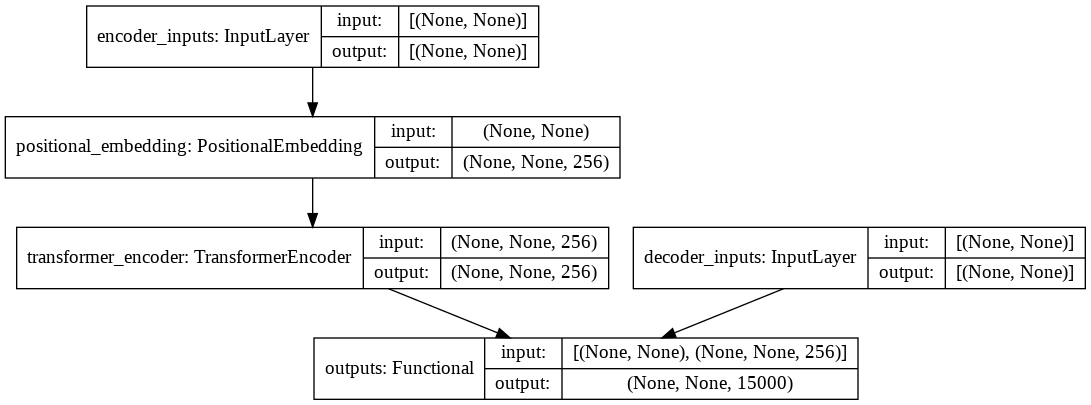

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Model Training


In [ ]:
model.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

I have pretrained the Model. You may use it to speed up the training.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(config.model_path, save_weights_only=True, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-4)
if config.use_pretrained_model:
    model_path = keras.utils.get_file(config.model_path, "https://github.com/LoniQin/english-spanish-translation-switch-transformer/raw/main/" + config.model_path)
    model.load_weights(model_path)
    # Just to save time. You may need to adjust code for further training here.
    model.fit(train_ds.take(100), epochs=1, validation_data=valid_ds.take(10), callbacks=[checkpoint, reduce_lr])
else:
    model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, reduce_lr])

Epoch 1/10
1579/1579 [==============================] - 135s 85ms/step - loss: 2.8240 - accuracy: 0.6366 - val_loss: 2.7285 - val_accuracy: 0.6688
Epoch 2/10
1579/1579 [==============================] - 135s 85ms/step - loss: 2.6583 - accuracy: 0.6838 - val_loss: 2.6714 - val_accuracy: 0.6875
Epoch 3/10
1579/1579 [==============================] - 135s 85ms/step - loss: 2.5641 - accuracy: 0.7127 - val_loss: 2.6503 - val_accuracy: 0.6944
Epoch 4/10
1579/1579 [==============================] - 137s 87ms/step - loss: 2.5016 - accuracy: 0.7348 - val_loss: 2.6368 - val_accuracy: 0.7012
Epoch 5/10
1579/1579 [==============================] - 134s 85ms/step - loss: 2.4547 - accuracy: 0.7524 - val_loss: 2.6341 - val_accuracy: 0.7045
Epoch 6/10
1579/1579 [==============================] - 135s 85ms/step - loss: 2.4194 - accuracy: 0.7665 - val_loss: 2.6350 - val_accuracy: 0.7089
Epoch 7/10
1579/1579 [==============================] - 134s 85ms/step - loss: 2.3909 - accuracy: 0.7786 - val_loss: 2

## Translation


In [ ]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))
def decode_sequence(model, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = config.begin_token
    for i in range(config.sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == config.end_token:
            break
    return decoded_sentence

In [ ]:
model = get_model(config)
model.load_weights(config.model_path)
for i in np.random.choice(len(data), 30):
    item = data.iloc[i]
    translated = decode_sequence(model, item["english"])
    print("English:", item["english"])
    print("Spanish:", item["spanish"])
    print("Translated:", translated)

English: It is possible that you have already read this book.
Spanish: [start] Puede que ya hayas leído este libro. [end]
Translated: [start] es posible que ya hayas leído leer este libro [end]
English: I'm glad to see you again.
Spanish: [start] Me alegro de volver a veros. [end]
Translated: [start] me alegro de volver a verte [end]
English: The two countries will negotiate a settlement to the crisis.
Spanish: [start] Los dos países negociarán una solución a la crisis. [end]
Translated: [start] los dos países [UNK] [UNK] una solución [end]
English: She told him to try harder.
Spanish: [start] Ella le dijo que siguiera tratando. [end]
Translated: [start] ella le dijo que él [UNK] más difícil [end]
English: I don't want to talk about love.
Spanish: [start] No quiero hablar de amor. [end]
Translated: [start] no quiero hablar de amor [end]
English: She hired him as an interpreter.
Spanish: [start] Ella le contrató de intérprete. [end]
Translated: [start] ella le contrató como intérprete [

## References
- [Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity](https://arxiv.org/abs/2101.03961)
- [English-Spanish Translation: Transformer](https://www.kaggle.com/lonnieqin/english-spanish-translation-transformer)
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762v5)
- [Text classification with Switch Transformer](https://keras.io/examples/nlp/text_classification_with_switch_transformer/)
